In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Stock/BTC-USD (1).csv')

In [ ]:
# df = df.iloc[::-1]

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
df_close = df.reset_index()['Close'].astype('float32')

In [ ]:
df_close

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
2783    38469.093750
2784    38529.328125
2785    37750.453125
2786    39698.371094
2787    39460.621094
Name: Close, Length: 2788, dtype: float32

In [ ]:
df_close.shape

(2788,)

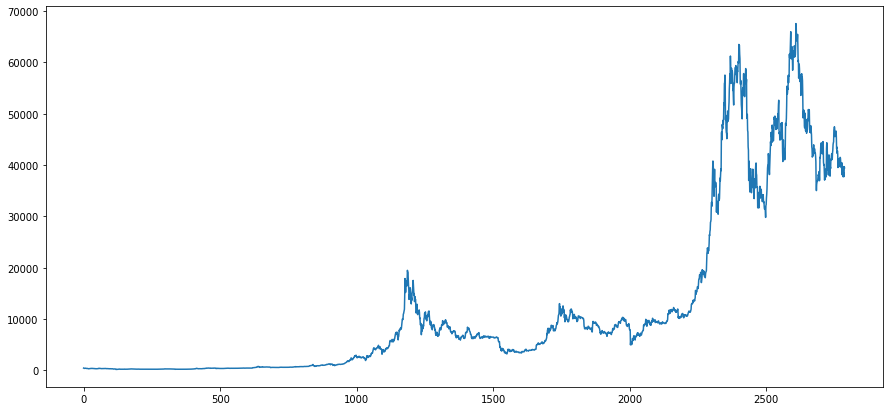

In [ ]:
plt.figure(figsize=(15,7))
df_close.plot()
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [ ]:
df_close.shape

(2788, 1)

In [ ]:
train_size = int(len(df_close)*0.85)
test_size = len(df_close) - train_size
train_data, test_data = df_close[:train_size, :], df_close[train_size:len(df_close), :1]

In [ ]:
train_size, test_size

(2369, 419)

In [ ]:
train_data.shape, test_data.shape

((2369, 1), (419, 1))

In [ ]:
def create_dataset(dataset, time_step=1):
  dataX = []
  dataY = []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 60
next_day = 7

In [ ]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, X_test.shape

((2308, 60), (358, 60))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 91,251
Trainable params: 91,251
Non-traina

In [ ]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64
)

Epoch 1/100
37/37 [==============================] - 19s 149ms/step - loss: 0.0029 - val_loss: 0.1247
Epoch 2/100
37/37 [==============================] - 3s 85ms/step - loss: 0.0016 - val_loss: 0.0425
Epoch 3/100
37/37 [==============================] - 3s 85ms/step - loss: 7.7790e-04 - val_loss: 0.0204
Epoch 4/100
37/37 [==============================] - 3s 85ms/step - loss: 6.9688e-04 - val_loss: 0.0230
Epoch 5/100
37/37 [==============================] - 3s 84ms/step - loss: 6.1074e-04 - val_loss: 0.0113
Epoch 6/100
37/37 [==============================] - 3s 85ms/step - loss: 6.0510e-04 - val_loss: 0.0171
Epoch 7/100
37/37 [==============================] - 3s 85ms/step - loss: 5.5194e-04 - val_loss: 0.0067
Epoch 8/100
37/37 [==============================] - 3s 85ms/step - loss: 4.7404e-04 - val_loss: 0.0082
Epoch 9/100
37/37 [==============================] - 3s 86ms/step - loss: 3.8916e-04 - val_loss: 0.0241
Epoch 10/100
37/37 [==============================] - 3s 84ms/step - l

In [ ]:
losses = pd.DataFrame(model.history.history)

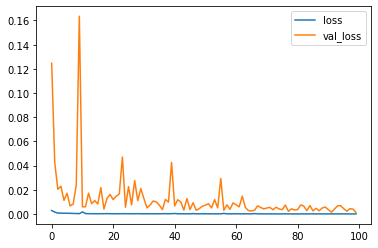

In [ ]:
losses.plot()
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
math.sqrt(mean_squared_error(y_train, train_predict))

9465.7830104012

In [ ]:
math.sqrt(mean_squared_error(y_test, test_predict))

45637.99680091141

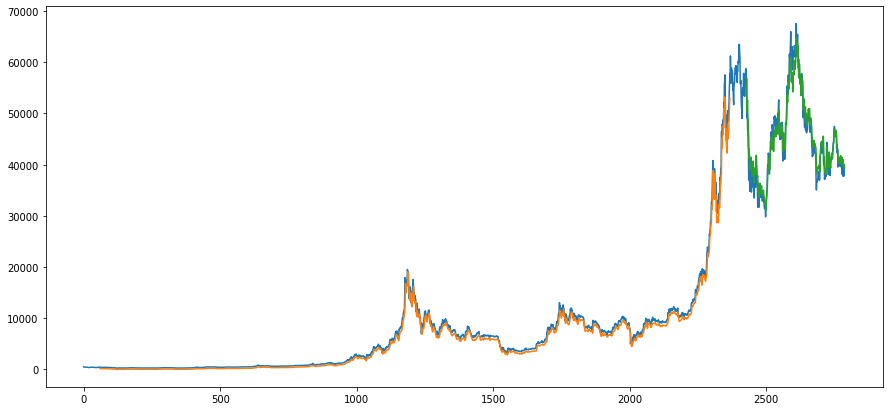

In [ ]:
look_back = time_step
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict

plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)-time_step

359

In [ ]:
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 60)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
lst_output = []
n_steps = time_step
i = 0
while(i<next_day):
  if(len(temp_input)>time_step):
    x_input = np.array(temp_input[1:])
    print(f'{i} day input {x_input}')
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    y_hat = model.predict(x_input, verbose=0)
    print(f'{i} day output {y_hat}')
    temp_input.extend(y_hat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(y_hat.tolist())
    i += 1
  else:
    x_input = x_input.reshape((1, n_steps, 1))
    y_hat = model.predict(x_input, verbose=0)
    print(y_hat[0])
    temp_input.extend(y_hat[0].tolist())
    print(len(temp_input))
    lst_output.extend(y_hat.tolist())
    i += 1

print(lst_output)

[0.60157937]
61
1 day input [0.57219017 0.62035334 0.58258051 0.57304645 0.57466447 0.55901873
 0.58598304 0.5811162  0.60790324 0.60504591 0.61765599 0.62343585
 0.60944498 0.60692483 0.6259312  0.63385755 0.64970553 0.65546018
 0.65771723 0.69213933 0.6967026  0.70171422 0.69573301 0.67311811
 0.68414325 0.67801911 0.68669444 0.68920386 0.67337507 0.63851386
 0.64292276 0.62487543 0.63221306 0.6236884  0.58383352 0.59281546
 0.60824162 0.58997124 0.59914118 0.59722722 0.58672798 0.60318857
 0.6132279  0.61132294 0.59875387 0.5870747  0.58331162 0.58305287
 0.59772915 0.56299263 0.57966697 0.58757192 0.57029897 0.55701858
 0.5682106  0.56910443 0.5575465  0.58645219 0.58292419 0.60157937]
1 day output [[0.6116242]]
2 day input [0.62035334 0.58258051 0.57304645 0.57466447 0.55901873 0.58598304
 0.5811162  0.60790324 0.60504591 0.61765599 0.62343585 0.60944498
 0.60692483 0.6259312  0.63385755 0.64970553 0.65546018 0.65771723
 0.69213933 0.6967026  0.70171422 0.69573301 0.67311811 0.684

In [ ]:
day_new = np.arange(1, time_step+1)
day_pred = np.arange(time_step+1, time_step+1+next_day)

In [ ]:
len(df_close)

2788

In [ ]:
df3 = df_close.tolist()
df3.extend(lst_output)

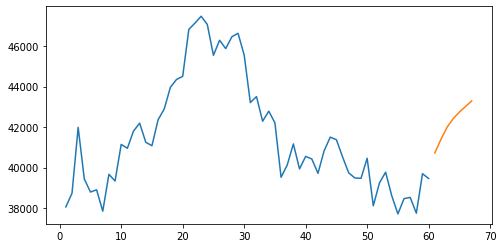

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(day_new, scaler.inverse_transform(df_close[len(df_close)-time_step:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.show()

In [ ]:
# Current price
current = scaler.inverse_transform(df_close[len(df_close)-100:])[-1]
print(f'Current price = {current[0]}')

Current price = 39460.62109375


In [ ]:
# Next 30 days price
next = scaler.inverse_transform(lst_output)[-1]
print(f'Next 7 days price = {next[0]}')

Next 7 days price = 43289.53479483093
